# Freedman-Diaconis rule
This rule gives an optimal width of the bin width or the histogram width to minimize the difference between actual area under the curve and bin-ed area under the curve. The bin width is given by:
![](https://i.imgur.com/GXYXvUY.png)
- x is the data sample
- IQR is the interquartile range
- n is the number of elements in sample
Technically speaking, 
> For a set of empirical measurements sampled from some probability distribution, the Freedman-Diaconis rule is designed to minimize the difference  between the area under the empirical probability distribution and the area under the theoretical probability distribution. - [sauce](https://www.revolvy.com/page/Freedman%E2%80%93Diaconis-rule)


# Python implementation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
sns.set_style('dark')

In [2]:
iris = datasets.load_iris()
X = pd.DataFrame(iris.data)
y = iris.target
Xtr, Xval, ytr, yval = train_test_split(X, y)

In [3]:
rf = RandomForestClassifier(n_estimators=20, random_state=42)
rf.fit(Xtr, ytr)
y_preds = rf.predict(Xval)
print(f"Continuous dataset predictions: {accuracy_score(y_preds, yval)}")

Continuous dataset predictions: 0.9473684210526315


# Convert to categorical variables

### Freedman-Diaconis

In [4]:
def make_bins(df, augment=False):
    mydf = df.copy()
    for col in mydf.columns:
        IQR = mydf[col].quantile([0.75]).values - mydf[col].quantile([0.25]).values 
        n = mydf.shape[0] 
        bin_size = 2 * IQR / (n ** (1/3)) 
        bin_number = int((mydf[col].max() - mydf[col].min())/bin_size)
        if augment:
            key = f"{col}_cat"
        else:
            key = col
        mydf[key] = pd.cut(mydf[col], bins = bin_number, labels = range(bin_number)).astype('float')
    return mydf

In [5]:
X_prime = make_bins(X)
Xtr, Xval, ytr, yval = train_test_split(X_prime, y)

In [6]:
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(Xtr, ytr)
y_preds = rf.predict(Xval)
print(f"Continuous dataset predictions: {accuracy_score(y_preds, yval)}")

Continuous dataset predictions: 0.8947368421052632


# Plots

In [7]:
X_aug = make_bins(X, augment=True)
X_aug.head()

,0,1,2,3,0_cat,1_cat,2_cat,3_cat
0,5.1,3.5,1.4,0.2,1.0,7.0,0.0,0.0
1,4.9,3.0,1.4,0.2,1.0,4.0,0.0,0.0
2,4.7,3.2,1.3,0.2,0.0,5.0,0.0,0.0
3,4.6,3.1,1.5,0.2,0.0,5.0,0.0,0.0
4,5.0,3.6,1.4,0.2,1.0,7.0,0.0,0.0


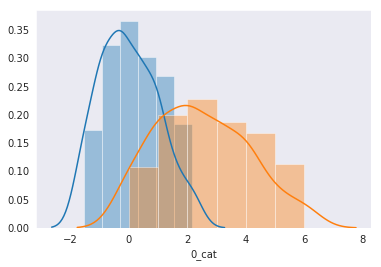

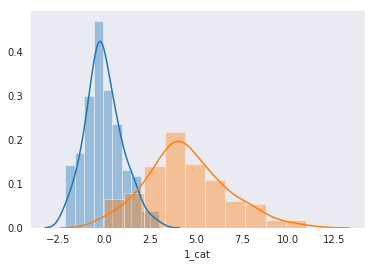

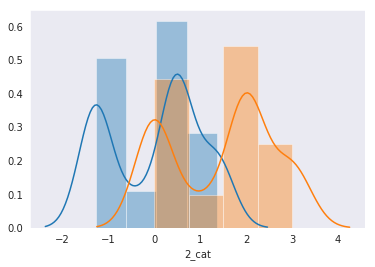

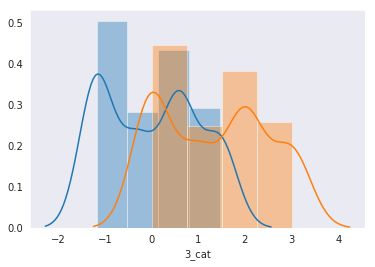

In [9]:
for i in range(len(X_aug.columns)//2):
    X_aug[i] = (X_aug[i] - X_aug[i].mean()) / X_aug[i].std()    
    X_aug[i] = (X_aug[f"{i}_cat"] - X_aug[f"{i}_cat"].mean()) / X_aug[f"{i}_cat"].std()    
    sns.distplot(X_aug[i])
    sns.distplot(X_aug[f"{i}_cat"])
    plt.show()

This isn't always the best way to choose the bin width, for small datasets like this one creating bin isn't even needed. For larger sets, always try freedman-diaconis rule first and then check by setting other fixed bin sizes if the model performs better. Remember: Tree based algos perform better on categorical variables, this can be very important in some cases.